In [49]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [50]:
#default_exp classify_image

In [98]:
#export
from food.tools import *
from food.paths import *
from food.psql import *
import requests
from food.qdrant import *

In [132]:
collection_name = 'food'
table = 'foods'

In [133]:
#export
foods = read_sql(table)
# foods = foods.drop(columns = ['clip'])
foods = foods.set_index('id')

In [134]:
client.get_collections()

['glovo', 'fundation_food', 'food']

In [135]:
#export
def search_image(url=None,head = 1):
    image_clip = requests.post(f'https://guru.skynet.center/image2vector/?url={url}').json()
    results = client.search(collection_name=collection_name,query_vector=image_clip,top=head)
    df = foods.loc[[r.id for r in results]].copy()
    df['score'] = [r.score for r in results]
    df = df.sort_values('score',ascending=False)

    return df.reset_index()

In [136]:
url = 'https://d18mqtxkrsjgmh.cloudfront.net/public/2021-03/Eating%20More%20Ultraprocessed%20%E2%80%98Junk%E2%80%99%20Food%20Linked%20to%20Higher%20CVD%20Risk.jpeg'

In [137]:
search_image(url)

,id,description,category,energy,protein,carb,fat,clip,score
0,1104592,Industrial oil as ingredient in food,Not included in a food category,892.0,0.0,0.0,100.0,"[-0.009690343, -0.0032188592, 0.005953133, 0.0...",0.243913


In [138]:
import numpy as np
import torch
from torch.nn import CosineSimilarity
cos = CosineSimilarity(dim=1, eps=1e-08)

In [142]:
url = 'http://glovo.away.guru/photos_resized/BYNSZMM_0014486_2088305720.png'
df = search_image(url,head=50)

clip = torch.tensor([np.array(c) for c in df['clip'].values])


best = df.sort_values("score",ascending=False).iloc[0].name
df['score1'] =cos(clip, clip[best])
df['score2'] =cos(clip, clip[df.sort_values("score1",ascending=False).iloc[-1].name])
for i in range(3,10):
    df[f'score{i}'] =cos(clip, clip[df[df.columns[df.columns.str.contains('score')]]         .sum(1).sort_values().index[0]])

In [143]:
r = df[(df[df.columns[df.columns.str.contains('score')]]==1).any(1)]

In [144]:
r['description'].tolist()

['Fish in lemon-butter sauce with starch item, vegetable, frozen meal',
 'Potato only from Puerto Rican mixed dishes, gravy and other components reported separately',
 'Perch, coated, fried, made with oil',
 'Porgy, steamed or poached',
 'Porgy, cooked, NS as to cooking method',
 'Flounder, baked or broiled, made with margarine',
 'Mackerel cake or patty',
 'Potato salad, German style']

In [146]:
r.groupby('category').agg({'description':'count'}).sort_values('description',ascending = False)

,description
category,
Fish,4
Seafood mixed dishes,2
Mashed potatoes and white potato mixtures,1
"White potatoes, baked or boiled",1


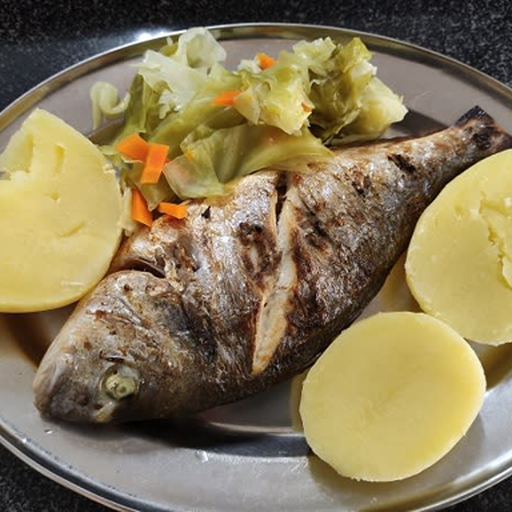

In [147]:
read_image_from_url(url)

In [45]:
read_image_from_url

NameError: name 'read_image_from_url' is not defined

In [107]:
!nbdev_build_lib

Converted 00_custom_pandas.ipynb.
Converted 00_paths.ipynb.
Converted 00_psql.ipynb.
Converted 00_qdrant.ipynb.
Converted 00_tools.ipynb.
Converted 01_classfy_image.ipynb.
Converted 0_template copy.ipynb.
Converted 0_template.ipynb.
Converted Untitled-1.ipynb.
Converted inference.ipynb.
Converted stats.ipynb.
Converted usda_parsing.ipynb.
